## Disclaimer

This notebook accompanies the paper:

*Multi-scale Topology Optimization using Neural Networks*.  
arXiv preprint [arXiv:2404.08708](https://arxiv.org/abs/2404.08708), 2024.

and 

*Heterogeneous Metamaterials Design via Multiscale Neural Implicit Representation*

The code is provided for academic and research purposes only. While we aim for clarity and reproducibility, this implementation may not cover all aspects of the paper, and some details may be simplified or adapted for illustrative purposes.

If you use this code or build upon it in your own work, please cite the above paper.

---

## License

This project is licensed under the [Apache License 2.0](https://www.apache.org/licenses/LICENSE-2.0).  
You are free to use, modify, and distribute this code under the terms of the license. See the `LICENSE` file for details.

---

**Note:** This code is provided "as is", without warranty of any kind, express or implied. The authors are not responsible for any damages or issues arising from the use of this code.


In [1]:
import numpy as np

from scipy.sparse import coo_matrix, csc_matrix, hstack, vstack
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from IPython import display

import math as m


# Get a list of all available GPUs
gpus = tf.config.list_physical_devices('GPU')

# Disable GPU if available
if gpus:
    try:
        tf.config.set_visible_devices([], 'GPU')
        print("GPU disabled, running on CPU")
    except RuntimeError as e:
        print(e)

GPU disabled, running on CPU


In [2]:
def HM2D(rho, Emax,Emin,nu,penal):
    nely,nelx = rho.shape

    k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
    KE = Emax/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
    [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
    [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
    [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
    [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
    [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
    [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
    [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);

    ndof = 2*(nelx+1)*(nely+1)
    dofs=np.arange(ndof)

    d1 = np.array([nely*2,nely*2+1, (nely+1)*(nelx+1)*2-2, (nely+1)*(nelx+1)*2-1, (nely+1)*(nelx)*2, (nely+1)*(nelx)*2+1, 0, 1])
    d3 = np.concatenate([np.arange(nely*2-2)+2, np.repeat((nely+1)*4-2+np.arange(nelx-1)*(nely+1)*2,2) +  np.tile([0, 1], nelx-1)])  
    d4 = np.concatenate([np.arange(nely*2-2)+2 + (nely+1)*(nelx)*2,  np.repeat( (nely+1)*2+np.arange(nelx-1)*(nely+1)*2 ,2) +  np.tile([0, 1], nely-1)])
    d2 = np.setdiff1d(np.arange(ndof),np.concatenate([d1,d3,d4]))

    e0 = np.eye(3)
    ufixed = np.zeros((8, 3))

    for j in range(3):
        ufixed[2:4, j] = np.dot(np.array([[e0[0, j], e0[2, j] / 2], [e0[2, j] / 2, e0[1, j]]]), np.array([[nelx], [0]])).flatten()
        ufixed[6:8, j] = np.dot(np.array([[e0[0, j], e0[2, j] / 2], [e0[2, j] / 2, e0[1, j]]]), np.array([[0], [nely]])).flatten()
        ufixed[4:6, j] = ufixed[2:4, j] + ufixed[6:8, j]

    wfixed = np.vstack([np.tile(ufixed[2:4, :], (nely - 1,1)), np.tile(ufixed[6:8, :], (nelx - 1,1))])
    
    edofMat=np.zeros((nelx*nely,8),dtype=int)
    for elx in range(nelx):
        for ely in range(nely):
            el = ely+elx*nely
            n1=(nely+1)*elx+ely
            n2=(nely+1)*(elx+1)+ely
            edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])

    iK = np.kron(edofMat,np.ones((8,1))).flatten()
    jK = np.kron(edofMat,np.ones((1,8))).flatten()
    Q_11,Q_12,Q_13,Q_22,Q_23,Q_33 = 0,0,0,0,0,0

    density = np.reshape(tf.transpose(rho),[1,-1])
    u=np.zeros((ndof,3))
    # solve
    sK=((KE.flatten()[np.newaxis]).T*(Emin+(1e-6+ density)**penal*(Emax-Emin))).flatten(order='F')
    K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
    K = K
    Kr1 = hstack([K[d2, :][:, d2], K[d2,:][:,d3] + K[d2,:][:, d4] ])
    Kr2 = hstack([K[d3,:][:, d2] + K[d4,:][:,d2] , K[d3,:][:,d3] + K[d4,:][:,d3] + K[d3,:][:,d4] + K[d4,:][:,d4]])
    Kr = vstack([Kr1, Kr2 ])

    u[d1,:] = ufixed
    KU = np.vstack([K[d2,:][:,d1].toarray(), K[d3,:][:,d1].toarray() + K[d4,:][:,d1].toarray()]) @ ufixed
    KW = np.vstack([K[d2,:][:,d4].toarray(), K[d3,:][:,d4].toarray() + K[d4,:][:,d4].toarray()]) @ wfixed

    u[np.hstack([d2,d3]), :] = spsolve(Kr.tocsc(),- KU - KW)

    u[d4,:] = u[d3,:] + wfixed

    Ei = Emin + density**penal*(Emax-Emin)
    qe_11 = np.sum((np.dot(u[edofMat,0].reshape(nelx*nely,8),KE) * u[edofMat,0].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)
    qe_12 = np.sum((np.dot(u[edofMat,0].reshape(nelx*nely,8),KE) * u[edofMat,1].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)
    qe_13 = np.sum((np.dot(u[edofMat,0].reshape(nelx*nely,8),KE) * u[edofMat,2].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)
    qe_22 = np.sum((np.dot(u[edofMat,1].reshape(nelx*nely,8),KE) * u[edofMat,1].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)
    qe_23 = np.sum((np.dot(u[edofMat,1].reshape(nelx*nely,8),KE) * u[edofMat,2].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)
    qe_33 = np.sum((np.dot(u[edofMat,2].reshape(nelx*nely,8),KE) * u[edofMat,2].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)

    Q_11,Q_12,Q_13,Q_22,Q_23,Q_33 = qe_11@Ei.T, qe_12@Ei.T, qe_13@Ei.T, qe_22@Ei.T, qe_23@Ei.T, qe_33@Ei.T
    
    ET = np.array([[Q_11,Q_12,Q_13],[Q_12,Q_22,Q_23],[Q_13,Q_23,Q_33]])

    dET = np.array([[qe_11.reshape([nely,nelx],order='F'),qe_12.reshape([nely,nelx],order='F'),qe_13.reshape([nely,nelx],order='F')],
                    [qe_12.reshape([nely,nelx],order='F'),qe_22.reshape([nely,nelx],order='F'),qe_23.reshape([nely,nelx],order='F')],
                    [qe_13.reshape([nely,nelx],order='F'),qe_23.reshape([nely,nelx],order='F'),qe_33.reshape([nely,nelx],order='F')]]) * penal * rho **(penal-1.0)

    return ET[:,:,0], dET
                  

def elementMatVec2D(a, b, DH):
    GaussNodes = np.array([-1 / np.sqrt(3), 1 / np.sqrt(3)])
    GaussWeight = np.array([1, 1])
    L = np.array([[1, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 1, 1, 0]])
    Ke = np.zeros((8, 8))
    
    for i in range(len(GaussNodes)):
        for j in range(len(GaussNodes)):
            GN_x = GaussNodes[i]
            GN_y = GaussNodes[j]
            dN_x = 1 / 4 * np.array([-(1 - GN_x), (1 - GN_x), (1 + GN_x), -(1 + GN_x)])
            dN_y = 1 / 4 * np.array([-(1 - GN_y), -(1 + GN_y), (1 + GN_y), (1 - GN_y)])
            J = np.dot(np.vstack((dN_x, dN_y)), np.array([[-a, a, a, -a], [-b, -b, b, b]]).T)
            G = np.block([[np.linalg.inv(J), np.zeros_like(J)],
                          [np.zeros_like(J), np.linalg.inv(J)]])
            dN = np.zeros((4, 8))
            dN[0,0:8:2] = dN_x
            dN[1,0:8:2] = dN_y
            dN[2,1:8:2] = dN_x
            dN[3,1:8:2] = dN_y
            Be = (L @ G) @ dN
            Ke += GaussWeight[i] * GaussWeight[j] * np.linalg.det(J) * (Be.T @ DH @ Be)
    
    return Ke



In [3]:

Macro_nelx = 20
Macro_nely = 10
Macro_length = Macro_nelx
Macro_width = Macro_nely 

Macro_vf = 0.3 

Macro_nelm = max(Macro_nelx,Macro_nely)
Macro_elex = Macro_length / Macro_nelx
Macro_eley = Macro_width / Macro_nely
Macro_nele = Macro_nelx * Macro_nely

Micro_nelx = 20
Micro_nely = 20
Micro_vf = 0.5
Micro_nelm = max(Micro_nelx,Micro_nely)
Micro_nele = Micro_nelx * Micro_nely

n_ss = 4  # sub-sampling factor per macro element dimension
E0 = 1.0
Emin = 1e-9
nu = 0.3
penal = 3.0


Macro_ndof = 2 * (Macro_nelx + 1) * (Macro_nely + 1) 
Macro_index = np.arange(Macro_nele).reshape([Macro_nely,Macro_nelx],order='F')

idx = Macro_nelx-1 
idy = int(Macro_nely)-1

loadnid = (idx+1) * 2 * (Macro_nely+1) + 1 + (idy+1) *2 #force node id for y direction 
force = np.zeros((Macro_ndof,1))
force[loadnid] = -1.0

F = force

fixeddofs= np.arange(Macro_ndof)[0:2*(Macro_nely+1):1]

freedofs = np.setdiff1d(np.arange(Macro_ndof),fixeddofs);

edofMat=np.zeros((Macro_nelx*Macro_nely,8),dtype=int)
for elx in range(Macro_nelx):
    for ely in range(Macro_nely):
        el = ely+elx*Macro_nely
        n1=(Macro_nely+1)*elx+ely
        n2=(Macro_nely+1)*(elx+1)+ely
        edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])

iK = np.kron(edofMat,np.ones((8,1))).flatten()
jK = np.kron(edofMat,np.ones((1,8))).flatten()

In [4]:
def elementMatVec2D_Batch(a, b, DH_batch):

    nely, nelx, _, _ = DH_batch.shape
    Ke_batch = np.zeros((nely, nelx, 8, 8))

    # 2x2 Gauss quadrature
    GaussNodes = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])
    GaussWeight = np.array([1,1])

    X_e = np.array([[-a, -b],
                    [ a, -b],
                    [ a,  b],
                    [-a,  b]])  # (4,2)
    L = np.array([[1, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 1, 1, 0]])
    for i_gx, gx in enumerate(GaussNodes):
        for i_gy, gy in enumerate(GaussNodes):
            dN_x = 0.25 * np.array([-(1 - gx), (1 - gx), (1 + gx), -(1 + gx)])
            dN_y = 0.25 * np.array([-(1 - gy), -(1 + gy), (1 + gy), (1 - gy)])
            J = np.vstack((dN_x, dN_y)) @ X_e  # shape (2,2)
            invJ = np.linalg.inv(J)
            G = np.block([
                [invJ,           np.zeros_like(invJ)],
                [np.zeros_like(invJ), invJ]
            ])  # shape (4,4)

            dN = np.zeros((4, 8))
            dN[0,0::2] = dN_x
            dN[1,0::2] = dN_y
            dN[2,1::2] = dN_x
            dN[3,1::2] = dN_y
            Be = (L @ G) @ dN  # shape (3,8)

            BTe = Be.T  # (8,3)

            tmp = np.einsum('ac,xycd->xya d', BTe, DH_batch)  

            Klocal = np.einsum('xyad,db->xyab', tmp, Be)
            fac = GaussWeight[i_gx] * GaussWeight[i_gy] * np.linalg.det(J)
            Ke_batch += fac * Klocal

    return Ke_batch

@tf.custom_gradient
def complianceMS(Macro_x_tf, Micro_x_tf):

    Macro_x = Macro_x_tf.numpy()        # (Macro_nely, Macro_nelx)
    Micro_x = Micro_x_tf.numpy()        # (Micro_nely, Micro_nelx, Macro_nele)

    sK = np.zeros((64 * Macro_nele,))  
    Ke_all = np.zeros((8,8,Macro_nele))  
    dDH_all = np.zeros((3,3,Micro_nely,Micro_nelx,Macro_nele))
    for i in range(Macro_nele):
        DH, dDH = HM2D(Micro_x[:,:, i], E0, Emin, nu, penal)  
        dDH_all[:,:,:,:,i] = dDH  
        Ke_all[:,:,i] = elementMatVec2D(Macro_length/(2*Macro_nelx), 
                                        Macro_width/(2*Macro_nely), 
                                        DH)

        ely, elx = np.argwhere(Macro_index==i)[0]
        factor = Emin + Macro_x[ely,elx]**penal*(E0 - Emin)
        sK_i = factor * Ke_all[:,:,i].ravel(order='F')  # 64
        start = i*64
        sK[start:start+64] = sK_i

    K = coo_matrix((sK,(iK,jK)), shape=(Macro_ndof,Macro_ndof)).tocsc()
    K = (K + K.T)*0.5
    U = np.zeros([Macro_ndof,1])
    U[freedofs,0] = spsolve(K[freedofs,:][:,freedofs], F[freedofs,0])

    Ue = U[edofMat].reshape(Macro_nele,8)
    ce = np.zeros((Macro_nele,))
    for i in range(Macro_nele):
        ce[i] = np.dot(Ue[i], Ke_all[:,:,i] @ Ue[i])

    Macro_x_p = Macro_x**penal
    factors = Emin + Macro_x_p*(E0 - Emin)  
    cvals = np.zeros((Macro_nele,))
    for i in range(Macro_nele):
        ely, elx = np.argwhere(Macro_index==i)[0]
        cvals[i] = factors[ely,elx]*ce[i]
    c = np.sum(cvals)

    Macro_dc = np.zeros((Macro_nely, Macro_nelx))
    for i in range(Macro_nele):
        ely, elx = np.argwhere(Macro_index==i)[0]
        Macro_dc[ely, elx] = penal*(E0 - Emin)*(Macro_x[ely, elx]**(penal-1.0))*ce[i]

    Micro_dc = np.zeros([Micro_nely, Micro_nelx, Macro_nele])
    for j in range(Macro_nele):
        dDH_j = np.transpose(dDH_all[:,:,:,:,j], (2,3,0,1))
        dKe_batch = elementMatVec2D_Batch(Macro_length/Macro_nelx,
                                          Macro_width/Macro_nely,
                                          dDH_j)
        u_j = Ue[j]  # shape (8,)
        tmp = np.einsum('a,yxab->yx b', u_j, dKe_batch)   # shape (micro_nely, micro_nelx, 8)
        dce_j = np.einsum('yxb,b->yx', tmp, u_j)          # shape (micro_nely, micro_nelx)
        ely, elx = np.argwhere(Macro_index==j)[0]
        factor_j = factors[ely, elx]

        Micro_dc[:,:,j] = factor_j * dce_j

    def grad(dy):
        dMacro = -dy * Macro_dc
        dMicro = -dy * Micro_dc
        return (tf.convert_to_tensor(dMacro, dtype=tf.float32),
                tf.convert_to_tensor(dMicro, dtype=tf.float32))

    return tf.convert_to_tensor(c, dtype=tf.float32), grad

In [5]:


alpha_init = 1
alpha_max = 100
alpha_delta = 0.25


c_x, c_y=np.meshgrid(np.linspace(0,(Macro_nely)/(Macro_nelm),Macro_nely,endpoint=False),
                                        np.linspace(0,(Macro_nelx)/(Macro_nelm),Macro_nelx,endpoint=False),indexing='ij')
Macro_dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])
Macro_dlX = tf.convert_to_tensor(Macro_dlX,dtype=tf.float32)


c_x, c_y=np.meshgrid(np.linspace(-(Micro_nelx)/(2*Micro_nelm),(Micro_nelx)/(2*Micro_nelm),Micro_nelx),
                                        np.linspace(-(Micro_nely)/(2*Micro_nelm),(Micro_nely)/(2*Micro_nelm),Micro_nely),indexing='ij')
dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])
dlX = tf.convert_to_tensor(dlX,dtype=tf.float32)



low_band = 0.0
high_band = 0.2
c_x, c_y=np.meshgrid(np.linspace(-high_band,high_band,10).reshape([-1]),
                                            np.linspace(-high_band,high_band,10).reshape([-1]),indexing='ij')

dlInit1 = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 0)
kernel1 = tf.Variable(dlInit1,trainable=True,dtype=tf.float32)
weights1 = tf.Variable(tf.zeros([dlInit1.shape[1],1]),trainable=True)

def rbnn1(coord):
    layer1 = tf.sin(tf.matmul(coord, 50.0*kernel1 ) + tf.ones([1,kernel1.shape[1]]))
    rho = tf.nn.sigmoid(tf.matmul(layer1,weights1))
    return rho


low_band = 0.0
high_band = 0.3
high_band2 = 0.6

c_x, c_y,c_1,c_2=np.meshgrid(np.linspace(-high_band,high_band,10).reshape([-1]),
                                    np.linspace(-high_band,high_band,10).reshape([-1]),
                                    np.linspace(-high_band2,high_band2,6).reshape([-1]),
                                    np.linspace(-high_band2,high_band2,6).reshape([-1]),indexing='ij')


dlInit2= np.stack((c_x.reshape([-1]),c_y.reshape([-1]),c_1.reshape([-1]),c_2.reshape([-1])),axis = 0)
kernel2 = tf.Variable(dlInit2,trainable=True,dtype=tf.float32)
weights2 = tf.Variable(tf.zeros([dlInit2.shape[1],1])+0.01,trainable=True)
def rbnn2(coord):
    layer1 = tf.sin(tf.matmul(coord, 50.0*kernel2) + tf.ones([1,kernel2.shape[1]]))
    rho = tf.nn.sigmoid(tf.matmul(layer1,weights2))
    return rho





In [6]:
g_x, g_y=np.meshgrid(np.linspace(0.2,0.7,Macro_nelx*n_ss+2),np.linspace(0.2,0.7,Macro_nely*n_ss+2),indexing='ij')
dlG = np.stack((g_x.reshape([-1]),g_y.reshape([-1])),axis = 1).reshape([Macro_nelx*n_ss+2,Macro_nely*n_ss+2,2])



def m_coords(idx, idy):

    dlXs = np.zeros([Micro_nele,4])

    dlXso = 1.2 *np.array(dlX)

    mxm = (dlXso[:,0]<= -0.5) 
    mxc = (dlXso[:,0]> -0.5) & (dlXso[:,0]< 0.5) 
    mxp = (dlXso[:,0]>= 0.5)
    mym = (dlXso[:,1]<= -0.5) 
    myc = (dlXso[:,1]> -0.5 ) & ( dlXso[:,1]< 0.5) 
    myp = (dlXso[:,1]>= 0.5)

    #n1,top left
    dlXs[mxm & myp,0:2] = dlXso[mxm & myp] + np.array([[1.0,-1.0]]) 
    dlXs[mxm & myp,2:] = dlG[idx,idy+2] 
    #n2, top center
    dlXs[mxc & myp,0:2] = dlXso[mxc & myp] + np.array([[0.0,-1.0]]) 
    dlXs[mxc & myp,2:] = dlG[idx+1,idy+2]
    #n3, top right
    dlXs[mxp & myp,0:2] = dlXso[mxp & myp] + np.array([[-1.0,-1.0]]) 
    dlXs[mxp & myp,2:] = dlG[idx+2,idy+2]
    #n4, center left
    dlXs[mxm & myc,0:2] = dlXso[mxm & myc] + np.array([[1.0,0.0]]) 
    dlXs[mxm & myc,2:] = dlG[idx,idy+1]
    #n5, center 
    dlXs[mxc & myc,0:2] = dlXso[mxc & myc] 
    dlXs[mxc & myc,2:] = dlG[idx+1,idy+1]
    #n6, center right
    dlXs[mxp & myc,0:2] = dlXso[mxp & myc] + np.array([[-1.0,0.0]]) 
    dlXs[mxp & myc,2:] = dlG[idx+2,idy+1]
    #n7,bottom left
    dlXs[mxm & mym,0:2] = dlXso[mxm & mym] + np.array([[1.0,1.0]]) 
    dlXs[mxm & mym,2:] = dlG[idx,idy]
    #n8, bottom center
    dlXs[mxc & mym,0:2] = dlXso[mxc & mym] + np.array([[0.0,1.0]]) 
    dlXs[mxc & mym,2:] = dlG[idx+1,idy]
    #n9, bottom right
    dlXs[mxp & mym,0:2] = dlXso[mxp & mym] + np.array([[-1.0,1.0]]) 
    dlXs[mxp & mym,2:] = dlG[idx+2,idy]


    return tf.convert_to_tensor(dlXs,dtype=tf.float32)

def m_coords_bc(idx, idy,neigh = True):

    dlXs = np.zeros([Micro_nele,4])
    dlXso = 1.1*np.array(dlX)


    mxm = (dlXso[:,0]<= -0.4) 
    mxc = (dlXso[:,0]> -0.4) & (dlXso[:,0]< 0.4) 
    mxp = (dlXso[:,0]>= 0.4)
    mym = (dlXso[:,1]<= -0.4) 
    myc = (dlXso[:,1]> -0.4 ) & ( dlXso[:,1]< 0.4) 
    myp = (dlXso[:,1]>= 0.4)

    #n1,top left
    dlXs[mxm & myp,0:2] = dlXso[mxm & myp] + np.array([[1.0,-1.0]]) 
    dlXs[mxm & myp,2:] = dlG[idx,idy+2] 
    #n2, top center
    dlXs[mxc & myp,0:2] = dlXso[mxc & myp] + np.array([[0.0,-1.0]]) 
    dlXs[mxc & myp,2:] = dlG[idx+1,idy+2]
    #n3, top right
    dlXs[mxp & myp,0:2] = dlXso[mxp & myp] + np.array([[-1.0,-1.0]]) 
    dlXs[mxp & myp,2:] = dlG[idx+2,idy+2]
    #n4, center left
    dlXs[mxm & myc,0:2] = dlXso[mxm & myc] + np.array([[1.0,0.0]]) 
    dlXs[mxm & myc,2:] = dlG[idx,idy+1]
    #n5, center 
    dlXs[mxc & myc,0:2] = dlXso[mxc & myc] 
    dlXs[mxc & myc,2:] = dlG[idx+1,idy+1]
    #n6, center right
    dlXs[mxp & myc,0:2] = dlXso[mxp & myc] + np.array([[-1.0,0.0]]) 
    dlXs[mxp & myc,2:] = dlG[idx+2,idy+1]
    #n7,bottom left
    dlXs[mxm & mym,0:2] = dlXso[mxm & mym] + np.array([[1.0,1.0]]) 
    dlXs[mxm & mym,2:] = dlG[idx,idy]
    #n8, bottom center
    dlXs[mxc & mym,0:2] = dlXso[mxc & mym] + np.array([[0.0,1.0]]) 
    dlXs[mxc & mym,2:] = dlG[idx+1,idy]
    #n9, bottom right
    dlXs[mxp & mym,0:2] = dlXso[mxp & mym] + np.array([[-1.0,1.0]]) 
    dlXs[mxp & mym,2:] = dlG[idx+2,idy]
    

    if not neigh:
        dlXs[:,:2] = dlXso
        dlXs[:,2:] = dlG[idx+1,idy+1]
        
    mk = np.ones([Micro_nele],dtype=bool)
    mk[mxc & myc] = False
    return tf.convert_to_tensor(dlXs[mk],dtype=tf.float32)


micro_dlX_subsamples   = [[] for _ in range(n_ss*n_ss)]
micro_dlX_bc_subsamples= [[] for _ in range(n_ss*n_ss)]
micro_dlX_bcn_subsamples=[[] for _ in range(n_ss*n_ss)]

for i in range(Macro_nelx):
    for j in range(Macro_nely):
        for si in range(n_ss):   # 0..n_ss-1 in x
            for sj in range(n_ss): # 0..n_ss-1 in y
                sub_idx = sj*n_ss + si
                Xcoords   = m_coords   (i*n_ss + si, j*n_ss + sj)
                BCcoords  = m_coords_bc(i*n_ss + si, j*n_ss + sj)
                BCcoordsN = m_coords_bc(i*n_ss + si, j*n_ss + sj, False)
                micro_dlX_subsamples[sub_idx].append(Xcoords)
                micro_dlX_bc_subsamples[sub_idx].append(BCcoords)
                micro_dlX_bcn_subsamples[sub_idx].append(BCcoordsN)

for sub_idx in range(n_ss*n_ss):
    micro_dlX_subsamples[sub_idx]    = tf.convert_to_tensor(micro_dlX_subsamples[sub_idx],    dtype=tf.float32)
    micro_dlX_bc_subsamples[sub_idx] = tf.convert_to_tensor(micro_dlX_bc_subsamples[sub_idx], dtype=tf.float32)
    micro_dlX_bcn_subsamples[sub_idx]= tf.convert_to_tensor(micro_dlX_bcn_subsamples[sub_idx],dtype=tf.float32)


SS = 1

c_x, c_y=np.meshgrid(np.linspace(-(Micro_nelx)/(2*Micro_nelm),(Micro_nelx)/(2*Micro_nelm),Micro_nelx*SS),
                                        np.linspace(-(Micro_nely)/(2*Micro_nelm),(Micro_nely)/(2*Micro_nelm),Micro_nely*SS),indexing='ij')
dlXSS = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])

In [7]:
to_optimizer = tf.keras.optimizers.Adam(learning_rate=0.004)
to_optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.004)
total_epoch = 0

c_0 = complianceMS(tf.ones([Macro_nely,Macro_nelx])*Macro_vf, tf.ones([Micro_nely,Micro_nelx,Macro_nele])*Micro_vf)

log_c = []
log_Macro_vf = []
log_Micro_vf = []

def m_coords2(idx, idy,scale=1.0):

    dlXs = np.zeros([Micro_nele*SS*SS,4])
    dlXso = np.array(dlXSS)

    dlXs[:,0:2] = dlXso*scale 
    dlXs[:,2:] = dlG[idx+1,idy+1]

    return tf.convert_to_tensor(dlXs,dtype=tf.float32)

def to_loss():

    global total_epoch 

    total_epoch = total_epoch+1
    alpha = min(alpha_init + alpha_delta * total_epoch , alpha_max)

    Macro_xPhys =rbnn1(Macro_dlX)
    sub_index = total_epoch % (n_ss*n_ss)
    Micro_dlX   = micro_dlX_subsamples[sub_index]
    Micro_dlX_bc= micro_dlX_bc_subsamples[sub_index]
    Micro_dlX_bcn=micro_dlX_bcn_subsamples[sub_index]

    Micro_xPhys = rbnn2(Micro_dlX)[:,:,0]
    Micro_xPhys = tf.transpose(Micro_xPhys)
    L2 = tf.reduce_mean((weights2)**2)
    if total_epoch<20:
        L1_diff = 0.0
    else:
        L1_diff = tf.reduce_mean(tf.abs(rbnn2(Micro_dlX_bc) - rbnn2(Micro_dlX_bcn))) * (alpha/10.0)
    Micro_xPhys_h = tf.reshape(Micro_xPhys, [Micro_nely,Micro_nelx,Macro_nele])
    
    Micro_xPhys_h = tf.transpose(Micro_xPhys_h,perm = [1,0,2])

    c = complianceMS(tf.reshape(Macro_xPhys,[Macro_nely,Macro_nelx]), Micro_xPhys_h)
    vf_macro = tf.math.reduce_mean(Macro_xPhys)
    vf_micro= tf.math.reduce_mean(Micro_xPhys,axis=0)
    

    loss = 100*L2 + L1_diff+ 1.0*c/c_0+alpha*(vf_macro/Macro_vf-1.0)**2  + tf.reduce_mean(alpha*(vf_micro/Micro_vf-1.0)**2 )
    

    tf.print('Epoch:',total_epoch,',Penal:',penal,',Alpha:',alpha)
    tf.print('Compliance:',c)
    tf.print(f'VF macro: {vf_macro}, micro: {vf_micro}')
    tf.print('Total Loss:',loss)
    
    log_c.append(c)
    log_Macro_vf.append(vf_macro)
    log_Micro_vf.append(vf_micro)
    return loss        

def plot_params():
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.title('compliance vs Iteration')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    
    plt.plot(log_c)
    
    plt.subplot(1,3,2)
    plt.title('macro vf vs Iteration')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.plot(log_Macro_vf)

    plt.subplot(1,3,3)
    plt.title('microvf vs Iteration')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.plot(log_Micro_vf)

    plt.show()

def plot_xPhys():

    combined = np.zeros([        Micro_nelx*Macro_nelx*SS*n_ss,        Micro_nely*Macro_nely*SS*n_ss    ])

    for j in range(Macro_nely*n_ss):
        for i in range(Macro_nelx*n_ss):
            dlXss = m_coords2(i, j, 1.0)
            xPhys_m = rbnn2(dlXss).numpy().reshape([Micro_nelx*SS, Micro_nely*SS])
            combined[ i*(Micro_nelx*SS):(i+1)*(Micro_nelx*SS), j*(Micro_nely*SS):(j+1)*(Micro_nely*SS) ] = xPhys_m

    combined = np.rot90(combined)
    combined = np.flip(combined,axis=0)

    plt.figure(figsize = (5,5),dpi=100)
    plt.imshow(combined,vmin=0, vmax=1,cmap = 'seismic')
    plt.axis("off")

    plt.figure(figsize = (10,10))
    xPhys = rbnn1(Macro_dlX) 
    plt.imshow(xPhys.numpy().reshape([Macro_nely,Macro_nelx]),vmin=0, vmax=1,cmap = 'seismic')

    plt.show()


def fit_to(epochs):
    for epoch in range(epochs):

        if epoch%5==1:
            display.clear_output(wait=True)

            plot_xPhys()
            plot_params()
        with tf.GradientTape(persistent=True) as model_tape:

            loss = to_loss()

        param1 = [weights1,kernel1]
        grad1 = model_tape.gradient(loss,param1)
        to_optimizer.apply_gradients(zip(grad1, param1))
        param2 = [weights2,kernel2]
        grad2 = model_tape.gradient(loss,param2)
        to_optimizer2.apply_gradients(zip(grad2, param2))


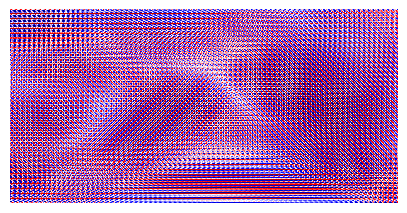

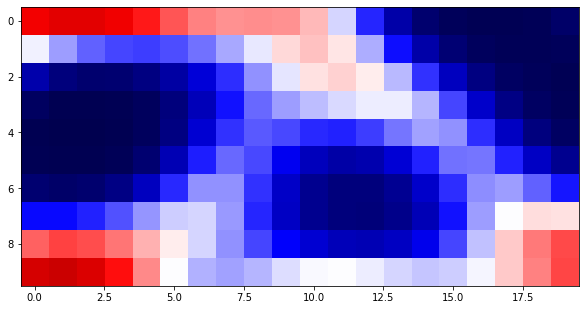

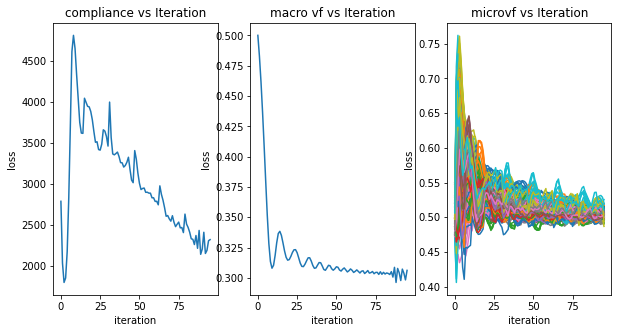

Epoch: 97 ,Penal: 3.0 ,Alpha: 25.25
Compliance: 2276.90576
VF macro: 0.3045651614665985, micro: [0.5175612  0.50906134 0.49834323 0.5010695  0.49880713 0.495771
 0.4958954  0.50961757 0.50993466 0.52672434 0.51763844 0.51576084
 0.49597988 0.5047601  0.49608257 0.49661013 0.50001055 0.5066776
 0.50270915 0.5315273  0.5131558  0.5139198  0.49205327 0.5079171
 0.49971434 0.49472347 0.502583   0.5003177  0.49924728 0.5237667
 0.5108925  0.50994015 0.48968557 0.5048002  0.4986565  0.49346915
 0.5044684  0.50439715 0.5052812  0.5120784  0.5136278  0.5141777
 0.49363503 0.50110406 0.49452895 0.49573126 0.50318027 0.5102695
 0.5079724  0.5062044  0.5123446  0.51630235 0.49986458 0.50149137
 0.49732456 0.49826446 0.49736688 0.5057972  0.5035986  0.5094202
 0.50706804 0.51592934 0.5019918  0.50220555 0.5040743  0.50304866
 0.49720147 0.50400406 0.50191295 0.5108522  0.50126547 0.5145274
 0.5031569  0.5007045  0.5038397  0.50541556 0.49893492 0.5055724
 0.50271153 0.5054164  0.49822727 0.5120986

In [8]:
fit_to(100)

(-0.5, 1599.5, 799.5, -0.5)

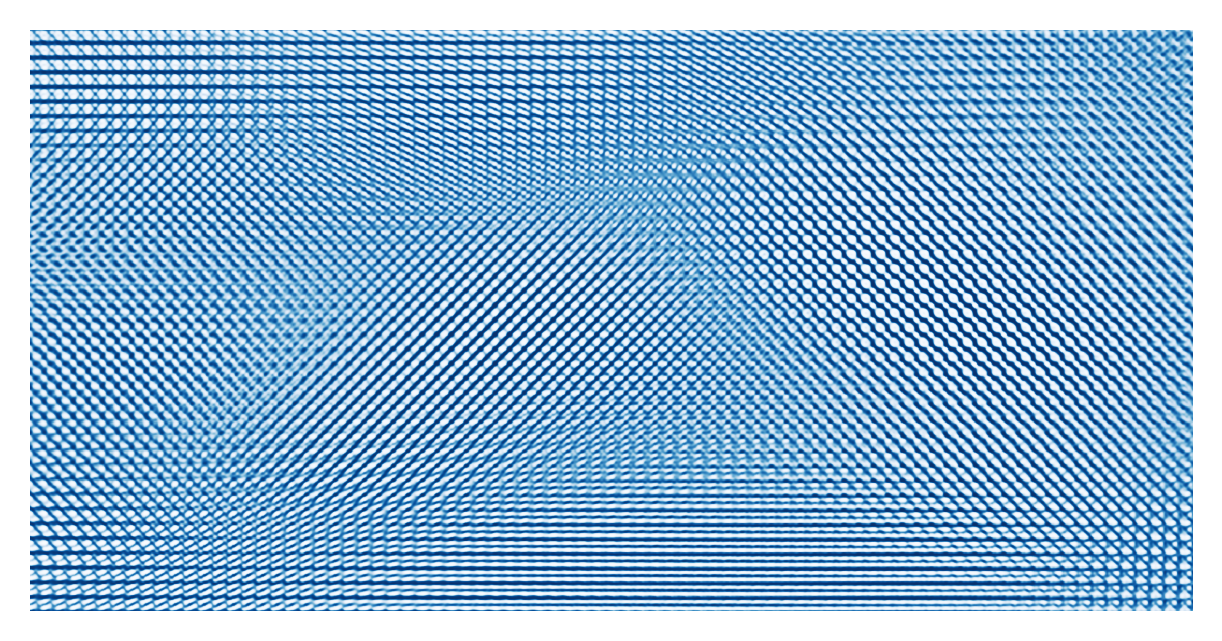

In [9]:
n_ss = 4
SS = 1

c_x, c_y=np.meshgrid(np.linspace(-(Micro_nelx)/(2*Micro_nelm),(Micro_nelx)/(2*Micro_nelm),Micro_nelx*SS),
                                        np.linspace(-(Micro_nely)/(2*Micro_nelm),(Micro_nely)/(2*Micro_nelm),Micro_nely*SS),indexing='ij')
dlXSS = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])
g_x, g_y=np.meshgrid(np.linspace(0.2,0.7,Macro_nelx*n_ss+2),np.linspace(0.2,0.7,Macro_nely*n_ss+2),indexing='ij')
dlG = np.stack((g_x.reshape([-1]),g_y.reshape([-1])),axis = 1).reshape([Macro_nelx*n_ss+2,Macro_nely*n_ss+2,2])

def m_coords2(idx, idy,scale=1.0):

    dlXs = np.zeros([Micro_nele*SS*SS,4])
    dlXso = np.array(dlXSS)

    dlXs[:,0:2] = dlXso*scale 
    dlXs[:,2:] = dlG[idx+1,idy+1]

    return tf.convert_to_tensor(dlXs,dtype=tf.float32)

combined = np.zeros([Micro_nelx*Macro_nelx*SS*n_ss, Micro_nely*Macro_nely*SS*n_ss])
for j in range(Macro_nely*n_ss):
    for i in range(Macro_nelx*n_ss):

        dlXss = m_coords2(i,j,1.0)#.numpy()
        #
        xPhys_m = rbnn2(dlXss).numpy().reshape([Micro_nelx*SS,Micro_nely*SS]) #* maskSS.numpy()

        combined[i*Micro_nelx*SS: (i+1)*Micro_nelx*SS, j*Micro_nely*SS: (j+1)*Micro_nely*SS] = xPhys_m
combined = np.rot90(combined,k=1)
combined = np.flip(combined,axis=0)


plt.figure(figsize = (5,3),dpi=300)
plt.imshow(combined,vmin=0, vmax=1,cmap = 'Blues')
plt.axis("off")


(-0.5, 1599.5, 799.5, -0.5)

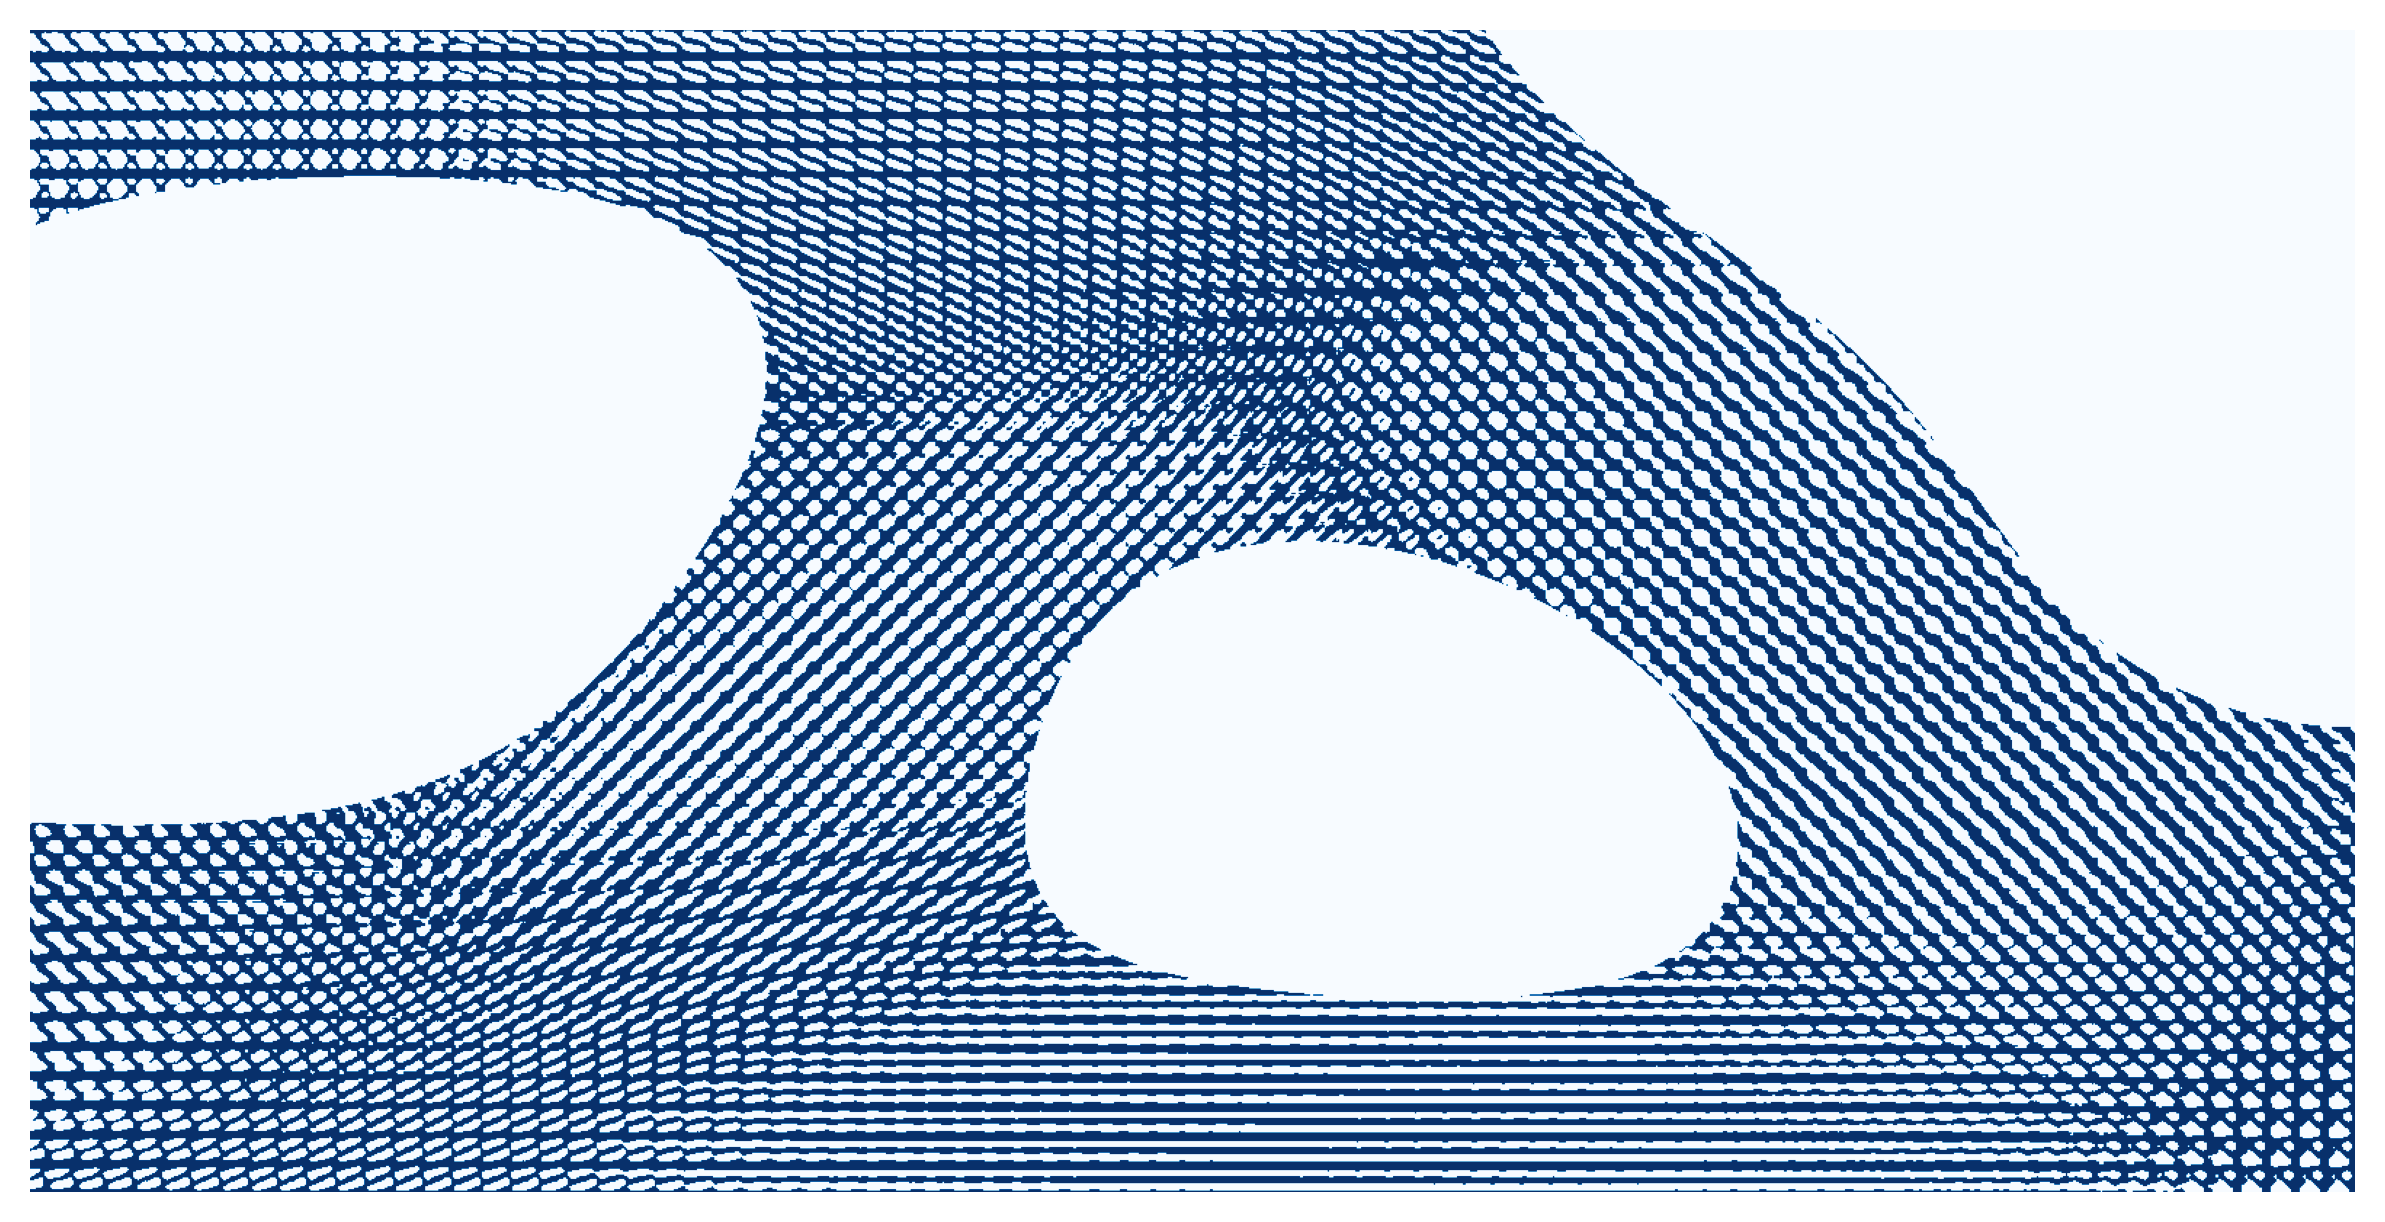

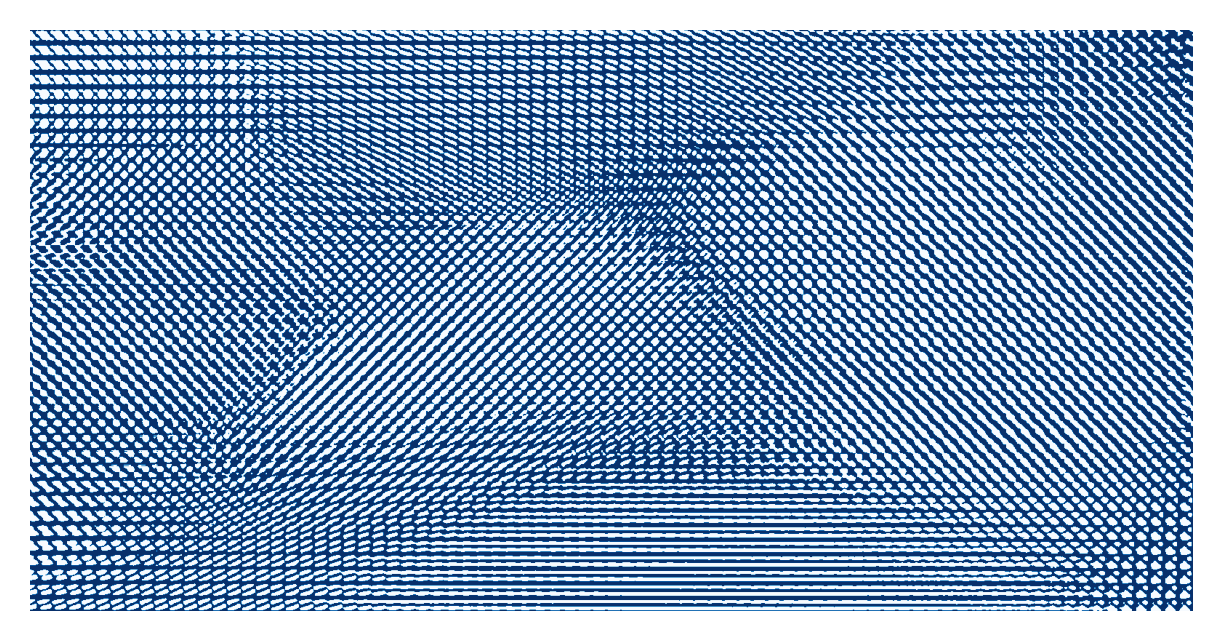

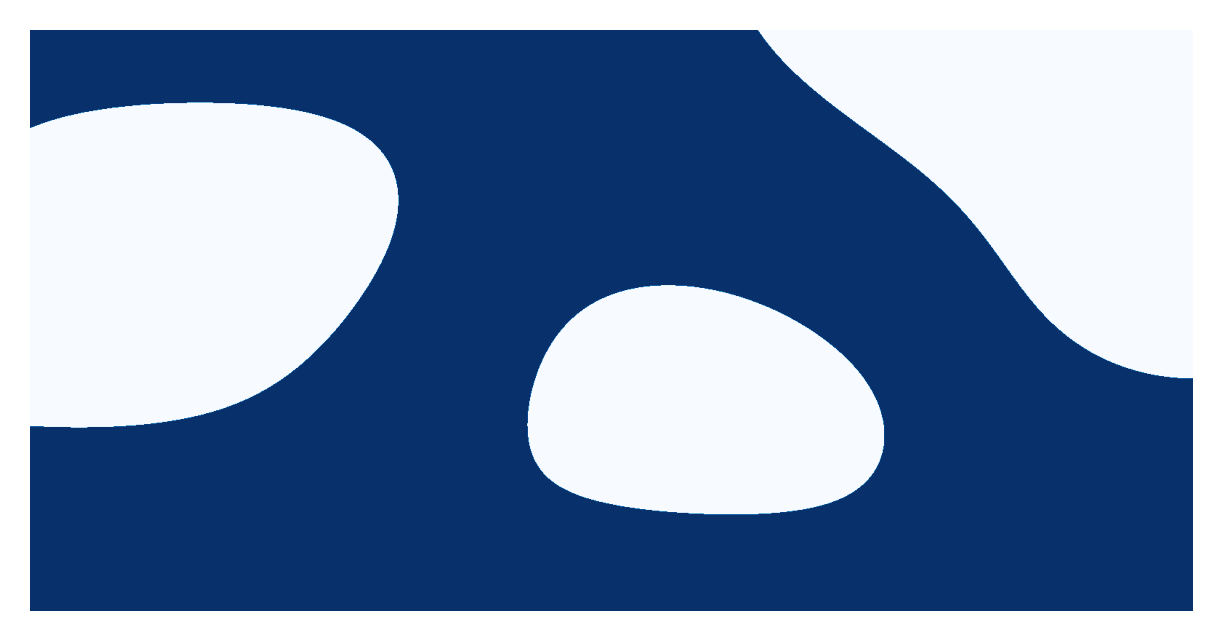

In [13]:
c_x, c_y=np.meshgrid(np.linspace(0,(Macro_nely)/(Macro_nelm),Macro_nely*SS*Micro_nely*n_ss,endpoint=False),
                                        np.linspace(0,(Macro_nelx)/(Macro_nelm),Macro_nelx*SS*Micro_nelx*n_ss,endpoint=False),indexing='ij')
Macro_dlXSS = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])
Macro_dlXSS = tf.convert_to_tensor(Macro_dlXSS,dtype=tf.float32)

xPhys = rbnn1(Macro_dlXSS).numpy().reshape([Macro_nely*SS*Micro_nely*n_ss,Macro_nelx*SS*Micro_nelx*n_ss])


plt.figure(figsize = (10,10),dpi=300)
plt.imshow((combined>0.4)*(xPhys>0.2),vmin=0, vmax=1,cmap = 'Blues')
plt.axis("off")


plt.figure(figsize = (5,3),dpi=300)
plt.imshow((combined>0.4),vmin=0, vmax=1,cmap = 'Blues')
plt.axis("off")



plt.figure(figsize = (5,3),dpi=300)
plt.imshow((xPhys>0.2),vmin=0, vmax=1,cmap = 'Blues')
plt.axis("off")

